<h1>Stamatics Summer Project</h1>
<h2>Bayesian Ranking and Analysis of Investment Strategies</h2>
<h4>Problem Statement 1: Data Exploration & Visualization</h>
ion
>
ion
h4>
ion

In [41]:
!pip install yfinance plotly scipy --quiet

In [42]:
from datetime import datetime
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import binom
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

In [43]:
start_date = datetime(year=2024, month=5, day=28)
end_date = datetime(year=2025, month=5, day=28)

def download_flat_yf(ticker, start, end):
    data = yf.download(ticker, start=start, end=end, progress=False)
    data.columns.name = None
    return data

stock_symbol = 'INFY.NS'
data = download_flat_yf(stock_symbol, start=start_date, end=end_date)

In [44]:
print(data.head())
print(data.describe())
print(data.isnull().sum())

Price             Close         High          Low         Open    Volume
Ticker          INFY.NS      INFY.NS      INFY.NS      INFY.NS   INFY.NS
Date                                                                    
2024-05-28  1410.366577  1418.970723  1403.877382  1418.490041   6186922
2024-05-29  1394.888550  1408.876418  1393.975303  1408.780305   7401634
2024-05-30  1372.296509  1393.831047  1366.624565  1387.053513   9663150
2024-05-31  1371.760498  1400.864924  1365.032813  1374.588090  37113815
2024-06-03  1370.785400  1404.033674  1368.932832  1404.033674  10589244
Price         Close         High          Low         Open        Volume
Ticker      INFY.NS      INFY.NS      INFY.NS      INFY.NS       INFY.NS
count    248.000000   248.000000   248.000000   248.000000  2.480000e+02
mean    1724.138574  1741.451140  1706.248872  1723.620307  7.092922e+06
std      171.698528   173.173793   171.624575   172.730935  4.172607e+06
min     1358.841309  1379.658033  1288.865511  1333

In [45]:
data['change'] = data['Close'].pct_change()
big_moves = data[abs(data['change']) > 0.04]
print(big_moves)

Price             Close         High          Low         Open    Volume  \
Ticker          INFY.NS      INFY.NS      INFY.NS      INFY.NS   INFY.NS   
Date                                                                       
2024-06-07  1495.295898  1501.243518  1440.353352  1444.009690  24075302   
2024-10-18  1832.653931  1888.474019  1822.562462  1846.499334  10526196   
2025-01-02  1930.685059  1935.418507  1859.141753  1860.818117   7083645   
2025-01-17  1790.260742  1832.220413  1786.858659  1825.317537  16409953   
2025-02-28  1664.283325  1730.748183  1659.106168  1730.698949  12182167   
2025-03-12  1568.777100  1614.188209  1542.102488  1614.188209  14870008   
2025-05-12  1604.327026  1609.356241  1510.743726  1515.674352  11372857   

Price         change  
Ticker                
Date                  
2024-06-07  0.041671  
2024-10-18 -0.044967  
2025-01-02  0.040027  
2025-01-17 -0.058596  
2025-02-28 -0.043417  
2025-03-12 -0.042579  
2025-05-12  0.079132  


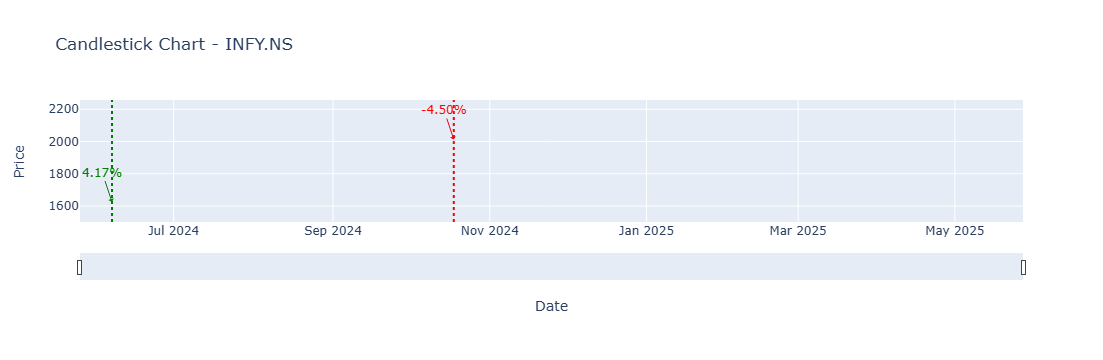

In [46]:
fig = go.Figure(data=[
    go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close']
    )
])

annotations = []
for idx, row in big_moves.head(2).iterrows():
    value = float(row['change'].iloc[0]) if isinstance(row['change'], pd.Series) else float(row['change'])
    color = 'green' if value > 0 else 'red'
    label = f"{value*100:.2f}%"
    annotations.append({
        "date": pd.Timestamp(idx),
        "label": label,
        "color": color
    })

for a in annotations:
    fig.add_vline(x=a["date"], line=dict(color=a["color"], width=2, dash="dot"))
    y_value = data.loc[a["date"], "High"]
    if isinstance(y_value, pd.Series):
        y_value = y_value.iloc[0]
    fig.add_annotation(
        x=a["date"],
        y=y_value,
        text=a["label"],
        showarrow=True,
        arrowhead=1,
        yshift=20,
        font=dict(color=a["color"]),
        arrowcolor=a["color"]
    )

fig.update_layout(title=f"Candlestick Chart - {stock_symbol}", xaxis_title='Date', yaxis_title='Price')
fig.show()

## 12 May 2025 (+7.9%):
Strong recovery; possible positive sentiment or institutional buying.
Volume above average suggests high investor interest.

## 7 June 2024 (▲ +4.1%):
Likely short-term profit booking after a previous gain.
High volume indicates active trading and possible technical move.

<h1> Problem Statement 2: Returns & Volatility</h1>
Returns measure the rate of change in stock prices. The two widely used measures of returns are as follows:

Simple Return: (P_t - P_{t-1}) / P_{t-1}
Log Return: log(P_t / P_{t-1})

In [47]:
data['Simple Return'] = (data['Close'] - data['Open']) / data['Open']
data['Log Return'] = np.log(data['Close'] / data['Open'])
data[['Simple Return', 'Log Return']].head()

Price,Simple Return,Log Return
Ticker,,
Date,,
2024-05-28,-0.005727,-0.005743
2024-05-29,-0.009861,-0.009910
2024-05-30,-0.010639,-0.010696
2024-05-31,-0.002057,-0.002059
2024-06-03,-0.023681,-0.023965


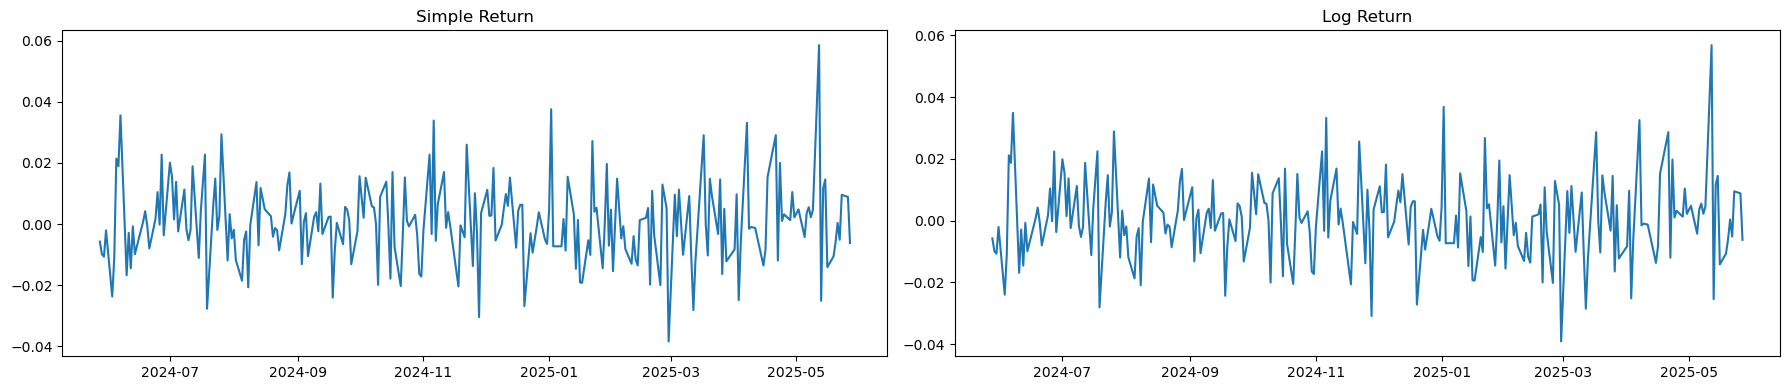

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

axes[0].plot(data.index, data['Simple Return'])
axes[0].set_title('Simple Return')

axes[1].plot(data.index, data['Log Return'])
axes[1].set_title('Log Return')

plt.tight_layout()
plt.show()

In [49]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="_plotly_utils.basevalidators")

fig = px.line(data, x=data.index, y='Rolling Std Dev', title='Rolling 14-Day Standard Deviation')
fig.show()

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of [('Close', 'INFY.NS'), ('High', 'INFY.NS'), ('Low', 'INFY.NS'), ('Open', 'INFY.NS'), ('Volume', 'INFY.NS'), ('change', ''), ('Simple Return', ''), ('Log Return', '')] but received: Rolling Std Dev

<h3>Simple Returns vs. Log Returns</h3>

Simple returns show how much a stock's price has changed in percentage from one day to the next. You can find it by doing: (Today’s Price - Yesterday’s Price) / Yesterday’s Price. For example, a return of 0.02 means the price went up by 2%. These are easy to understand but not great for looking at long-term changes because you can’t just add them over time.

Log returns are a bit different. They use the natural log of the ratio: log(Today’s Price / Yesterday’s Price). They are better for long-term analysis because you can add them across days. Log returns are also useful in financial models and when looking at risk.

<h1>Problem Statement 3: The Probability Paradox</h1>

In [22]:
data['Direction'] = np.where(data['Simple Return'] > 0, 'UP', 'DOWN')
p_up = (data['Direction'] == 'UP').mean()
print(f"P(UP) = {p_up:.2f}")

P(UP) = 0.50


In [23]:
prob_6_up = binom.pmf(6, 10, p_up)
prob_at_least_8_up = binom.sf(7, 10, p_up)

print(f"P(exactly 6 UP days in 10) = {prob_6_up:.4f}")
print(f"P(at least 8 UP days in 10) = {prob_at_least_8_up:.4f}")

P(exactly 6 UP days in 10) = 0.2017
P(at least 8 UP days in 10) = 0.0519


In [24]:
simulations = np.random.binomial(n=10, p=p_up, size=1000)
sim_prob_6_up = np.mean(simulations == 6)
sim_prob_at_least_8_up = np.mean(simulations >= 8)

print(f"Simulated P(exactly 6 UP days): {sim_prob_6_up:.4f}")
print(f"Simulated P(at least 8 UP days): {sim_prob_at_least_8_up:.4f}")

Simulated P(exactly 6 UP days): 0.2100
Simulated P(at least 8 UP days): 0.0560


In [25]:
avg_up_return = data[data['Direction'] == 'UP']['Simple Return'].mean()
avg_down_return = data[data['Direction'] == 'DOWN']['Simple Return'].mean()
total_return = (6 * avg_up_return) + (4 * avg_down_return)

print(f"Avg UP Return: {avg_up_return:.4%}")
print(f"Avg DOWN Return: {avg_down_return:.4%}")
print(f"Net Return for 6 UP & 4 DOWN days: {total_return:.4%}")

Avg UP Return: 1.0199%
Avg DOWN Return: -0.9134%
Net Return for 6 UP & 4 DOWN days: 2.4656%


To decide if a bet is good, the net return should be positive, meaning you make a profit.

Using this formula:
(100) × P(Up) – (150) × P(Down) = Return

Since P(Down) = 1 – P(Up), we can rewrite it as:
Return = 250 × P(Up) – 150

For the return to be positive, P(Up) must be greater than 0.6.

This means we should only take the bet if the chance of an up day is over 60%. Just having a high number of wins doesn’t always mean you will make money. That’s why many traders lose, even if they win often.

In [26]:
expected_value = (p_up * 100) + ((1 - p_up) * -150)
print(f"Expected Value of Bet: ₹{expected_value:.2f}")

Expected Value of Bet: ₹-26.01
